<a href="https://colab.research.google.com/github/mswaringen/aml_food/blob/master/KerasFeatureExtract_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/angqx95/feature-extractor-fine-tuning-with-keras

In [1]:
import numpy as np
import pandas as pd
import os
import torch as th
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.resnet50 import preprocess_input

from keras.applications import VGG16, resnet
from keras.layers import *
from keras.models import Model,Sequential
from keras import optimizers
from keras import regularizers
from keras import backend as K

In [2]:
downzip=True

if downzip:
  !mkdir data
  %cd data
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV" -O final-project-food-recognition-challenge.zip && rm -rf /tmp/cookies.txt
  !unzip final-project-food-recognition-challenge.zip
  %cd ..
  !mkdir outputs

Streaming output truncated to the last 5000 lines.
  inflating: train_set/train_set/train_55.jpg  
  inflating: train_set/train_set/train_550.jpg  
  inflating: train_set/train_set/train_5500.jpg  
  inflating: train_set/train_set/train_5501.jpg  
  inflating: train_set/train_set/train_5502.jpg  
  inflating: train_set/train_set/train_5503.jpg  
  inflating: train_set/train_set/train_5504.jpg  
  inflating: train_set/train_set/train_5505.jpg  
  inflating: train_set/train_set/train_5506.jpg  
  inflating: train_set/train_set/train_5507.jpg  
  inflating: train_set/train_set/train_5508.jpg  
  inflating: train_set/train_set/train_5509.jpg  
  inflating: train_set/train_set/train_551.jpg  
  inflating: train_set/train_set/train_5510.jpg  
  inflating: train_set/train_set/train_5511.jpg  
  inflating: train_set/train_set/train_5512.jpg  
  inflating: train_set/train_set/train_5513.jpg  
  inflating: train_set/train_set/train_5514.jpg  
  inflating: train_set/train_set/train_5515.jpg  
  i

In [3]:
df = pd.read_csv('data/train_labels.csv',dtype=str)
testdf = pd.read_csv('data/sample.csv',dtype=str)

Text(0.5, 1.0, 'Data Distribution')

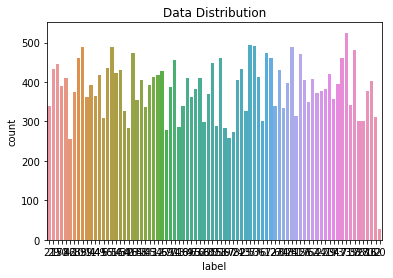

In [4]:
sns.countplot(x='label',data=df).set_title("Data Distribution")

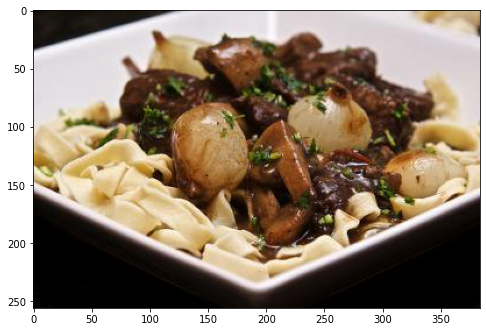

In [5]:
os.chdir('data/train_set/train_set')

img = load_img(df['img_name'].iloc[0]) 
  
# Displaying the image 
plt.figure(figsize=(8,8))
plt.imshow(img)

In [6]:
train_df, valid_df = train_test_split(df, test_size=0.25)
print(train_df.shape)
print(valid_df.shape)

(22959, 2)
(7653, 2)


In [7]:
batch_size = 32
img_size = 224

In [8]:
def generate_train_batch(model):
    
    if model == 'resnet':      #use of resnet requires its specific preprocessing_function for better accuracy for augmentation
        print('resnet data')
        train_datagen = ImageDataGenerator(
                    rotation_range=10,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    preprocessing_function = preprocess_input)

    else:
        train_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1)

    if model == 'vgg':   #VGG16 will only generate mini-batches of x_features; y_col=None as feature extractor
        print('vgg data')
        train_gen = train_datagen.flow_from_dataframe(
            train_df[['img_name']],
            x_col='img_name',
            y_col=None,
            target_size=(img_size, img_size),
            batch_size = batch_size,
            class_mode=None,
            shuffle=False)
        
    else:
        train_gen = train_datagen.flow_from_dataframe(
                    train_df,
                    x_col='img_name',
                    y_col='label',
                    target_size=(img_size, img_size),
                    batch_size = batch_size,
                    class_mode="categorical")

    return train_gen


def generate_valid_batch(model):
    if model == 'resnet':
        print('resnet validation set')
        valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
    else:
        valid_datagen = ImageDataGenerator(rescale=1./255)
        
    valid_gen = valid_datagen.flow_from_dataframe(
            valid_df,
            x_col='img_name',
            y_col='label',
            target_size=(img_size, img_size),
            batch_size = batch_size,
            class_mode="categorical")
    
    return valid_gen

train_gen = generate_train_batch('others')
valid_gen = generate_valid_batch('others')

Found 22959 validated image filenames belonging to 80 classes.
Found 7653 validated image filenames belonging to 80 classes.


Found 1 validated image filenames belonging to 1 classes.


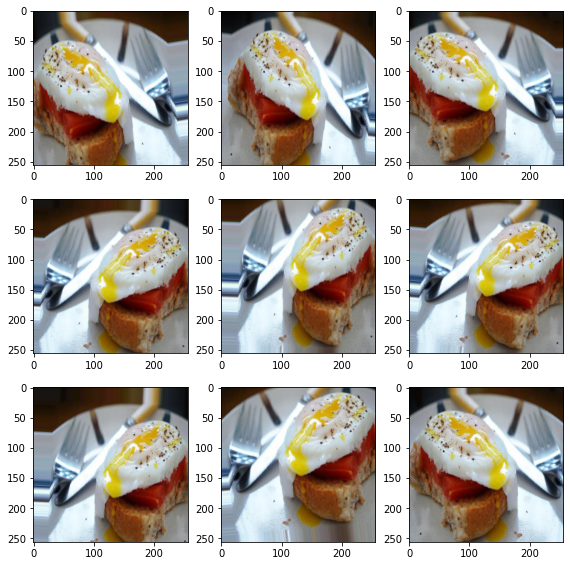

In [9]:
visual_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1)

visualise_df = train_df.sample(n=1).reset_index(drop=True)
visualisation_generator = visual_datagen.flow_from_dataframe(
    visualise_df,  
    x_col='img_name',
    y_col='label'
)
plt.figure(figsize=(8, 8))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in visualisation_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [10]:
K.clear_session()

In [11]:
#model instantiation
modelcnn=Sequential()
modelcnn.add(Conv2D(16, (3,3), activation="relu", input_shape=(img_size, img_size, 3)))
modelcnn.add(Conv2D(16, (3,3), activation="relu",))
modelcnn.add(MaxPooling2D((3,3)))

modelcnn.add(Conv2D(32, (3,3), activation="relu"))
modelcnn.add(Conv2D(32, (3,3), activation="relu"))
modelcnn.add(MaxPooling2D(2,2))

modelcnn.add(Conv2D(64, (3,3), activation="relu"))
modelcnn.add(Conv2D(64, (3,3), activation="relu"))
modelcnn.add(MaxPooling2D(2,2))
modelcnn.add(Dropout(0.3))

modelcnn.add(Conv2D(32, (3,3), activation="relu"))
modelcnn.add(MaxPooling2D((2,2)))

modelcnn.add(Flatten())
modelcnn.add(Dense(512, activation="relu"))
modelcnn.add(Dropout(0.5))
modelcnn.add(Dense(1, activation="sigmoid"))

modelcnn.compile(loss="binary_crossentropy", 
         optimizer=optimizers.RMSprop(lr=1e-4),
         metrics=["accuracy"])
modelcnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        1

In [ ]:
epochs = 5

history = modelcnn.fit(train_gen,
                    epochs=epochs,
                    validation_data=valid_gen,
                    verbose=1)

Epoch 1/5
718/718 [==============================] - 263s 367ms/step - loss: 0.0693 - accuracy: 0.9875 - val_loss: 0.0808 - val_accuracy: 0.9875
Epoch 2/5
718/718 [==============================] - 274s 381ms/step - loss: 0.0682 - accuracy: 0.9875 - val_loss: 0.0721 - val_accuracy: 0.9875
Epoch 3/5
195/718 [=======>......................] - ETA: 3:03 - loss: 0.0679 - accuracy: 0.9875

In [ ]:
loss, accuracy = modelcnn.evaluate(valid_gen, valid_gen.samples//batch_size, workers=12)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

In [ ]:
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
 
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [ ]:
plot_acc_loss(history)

### Feature Extraction

In [ ]:
vgg = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

for layers in vgg.layers:
    layers.trainable=False

print(vgg.output)

In [ ]:
feature_list = []
for path in train_df['img_name'].to_numpy():
    x = load_img(path,target_size=(img_size,img_size))
    img_array = img_to_array(x)
    img_array = np.expand_dims(img_array, axis=0)
    features = vgg.predict(img_array)
    feature_list.append(features)
    
feat_lst = np.reshape(feature_list,(-1,7*7*512))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

y = train_df['label'].to_numpy()  #convert df to numpy array with shape(18750,)

X_train, X_test, y_train, y_test = train_test_split(feat_lst, y, test_size=0.2, random_state=2020)

glm = LogisticRegression(C=0.1)
glm.fit(X_train,y_train)

In [ ]:
print("Accuracy on validation set using Logistic Regression: ",glm.score(X_test,y_test))

### Fine Tuning

In [ ]:
np.random.seed(2020)

res = resnet.ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

res_train_gen = generate_train_batch('resnet')
res_valid_gen = generate_valid_batch('resnet')


for layer in res.layers[:171]:
    layer.trainable=False
    

flat = Flatten()(res.output)   #Flatten the output layer from our Resnet model
dense = Dense(1024,activation='relu')(flat)
drop = Dropout(0.5)(dense)
classifier = Dense(1, activation='sigmoid')(drop)


res_model = Model(res.input, classifier)
optimizer=optimizers.Adam(1e-5)


res_model.compile(optimizer= optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
res_model.fit_generator(res_train_gen,
                    epochs=epochs,
                    validation_data=res_valid_gen,
                    validation_steps=res_train_gen.samples//batch_size,
                    steps_per_epoch = res_valid_gen.samples//batch_size)

In [ ]:
loss, accuracy = res_model.evaluate(res_valid_gen, res_valid_gen.samples//batch_size, workers=12)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

### Compare Models

In [ ]:
test_x = get_path('data/test_set/test_set')
testdf = pd.DataFrame({'img_name': test_x})
test_sample = testdf.sample(n=12, random_state=2020)

def test_img(model,name):
    result_lst = []
    for path in test_sample['filename'].to_numpy():
        full_path = '../test1/'+path
        x = load_img(full_path, target_size=(224,224))
        img_array = img_to_array(x)
        img_array = np.expand_dims(img_array, axis=0)
        if name == 'vgg':
            features = model.predict(img_array)
            features = np.reshape(features,(-1,7*7*512))
            result = glm.predict(features)
        else:
            result =  model.predict(img_array)
        
        result = 'dog' if float(result) >0.5 else 'cat'
        
        result_lst.append(result)
    return result_lst

In [ ]:
# get test predictions from all models
custom_cnn_result = test_img(modelcnn, 'cnn')
trflearn_result = test_img(vgg,'vgg')
finetune_result = test_img(res_model,'resnet')